# 🏦 Home Credit Default Risk Analysis (Full Dataset)

## Project Objective

This notebook presents a comprehensive end-to-end modeling pipeline for predicting default risk using the entire Home Credit dataset (not a sample). The goal is to identify clients who are likely to experience payment difficulties, based on extensive historical and application data.
We use CatBoost, a gradient boosting model particularly well-suited for handling categorical features natively, and apply Optuna to tune hyperparameters for maximum performance. This version of the notebook represents the final cleaned, tuned, and fully cross-validated model, ready for interpretation and, with further adjustments, deployment.

## Key Features

- **Data Source**: [Kaggle - Home Credit Default Risk](https://www.kaggle.com/competitions/home-credit-default-risk/data)
- **Data Used**: All relevant relational tables merged and aggregated appropriately (e.g., `bureau`, `previous_application`, `installments_payments`, etc.)
- **Target**: `TARGET` (1 = client experienced payment difficulties, 0 = otherwise)
- **Model**: [CatBoostClassifier](https://catboost.ai)
- **Tuning**: [Optuna](https://optuna.org/) hyperparameter optimization with stratified K-fold cross-validation
- **Evaluation Metrics**: AUC, Recall, Precision, F1-score, Confusion Matrix, and SHAP interpretability

## Notebook Structure

1. Data loading and merging — full dataset joins and preprocessing
2. Feature Engineering — statistical transformations
3. Train-Test Split — stratified split using full cleaned dataset
4. Initial Model Run — baseline CatBoost model
5. Optuna Hyperparameter Tuning — CV-based optimization
6. Threshold Tuning — adjusting classification decision boundary
7. Final Model Training & Evaluation**
8. SHAP Analysis — global and local interpretability of final model
9. Conclusion & Next Steps

## Why CatBoost?

- Handles categorical features directly without one-hot encoding
- Efficient with large datasets
- Excellent performance on tabular, structured data 

In [1]:
# === General Purpose ===
import os
import numpy as np
import pandas as pd

# === Modeling ===
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold, train_test_split
from scipy.stats.mstats import winsorize

# === Metrics ===
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score
)

# === Optimization ===
import optuna
from optuna.pruners import SuccessiveHalvingPruner

# === Visualization ===
import matplotlib.pyplot as plt
import seaborn as sns

# === SHAP Explainability ===
import shap

# Section 1: Data loading and merging 
- This section loads and integrates all the key relational tables from the Home Credit dataset into the main application data (`application_train` and `application_test`). 
- The goal is to create a fully-featured training and testing set, preserving as much signal as possible while handling multi-table relationships properly.

### 1.1 Raw File Import
- We load the `application_train.csv` and `application_test.csv` files.
- All auxiliary tables (`bureau`, `bureau_balance`, `previous_application`, `POS_CASH_balance`, `installments_payments`, and `credit_card_balance`) are read in full.
- A utility function `inspect()` is used to review basic metadata and sanity-check the tables.

In [2]:
# Load full train and test datasets
application_train = pd.read_csv("../data/application_train.csv")
application_test = pd.read_csv("../data/application_test.csv")

print(f"Train shape: {application_train.shape}")
print(f"Test shape: {application_test.shape}")

# Preview
application_train.head()

Train shape: (307511, 122)
Test shape: (48744, 121)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
def inspect(df, name="DataFrame"):
    print(f"\n{name} shape: {df.shape}")
    print("\nColumns:")
    print(df.columns.tolist())
    print("\nInfo:")
    print(df.info())
    print("\nPreview:")
    display(df.head())

# Inspect application_train
inspect(application_train, "Application Train")


Application Train shape: (307511, 122)

Columns:
['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATI

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


### 1.2 Relational Merging Workflow
Each related table is cleaned, aggregated, and merged into the main train/test DataFrames based on `SK_ID_CURR`. The logic below is modular so each aggregation is scoped and self-contained.

#### `bureau_balance`
- One-hot encodes the `STATUS` column.
- Aggregates monthly loan statuses by `SK_ID_BUREAU` using mean values.
- Merges into the `bureau` table.

#### `bureau`
- Aggregates numerical features by `SK_ID_CURR`.
- Merges bureau-level stats into both train and test sets.

#### `previous_application`
- Aggregates numeric stats by `SK_ID_CURR`.
- Merges into train/test.

#### `POS_CASH_balance`
- Aggregates installment and DPD-related fields by `SK_ID_PREV`.
- Then, groups again by `SK_ID_CURR` to derive one-row-per-loan features.
- Merges into train/test.

#### `installments_payments`
- Creates 3 engineered features: 
  - `PAYMENT_DIFF_DAYS`, `PAYMENT_RATIO`, `PAYMENT_DIFF_AMT`.
- Aggregates payment behavior by `SK_ID_PREV`, then again by `SK_ID_CURR`.
- Merges into train/test.

#### `credit_card_balance`
- Aggregates all credit card usage stats by `SK_ID_PREV`, then `SK_ID_CURR`.
- Merges final credit card stats into train/test.


In [4]:
# Load full bureau table
bureau = pd.read_csv("../data/bureau.csv")
inspect(bureau, "Bureau")


Bureau shape: (1716428, 17)

Columns:
['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE', 'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_D

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [5]:
# Load full bureau_balance table
bureau_bal = pd.read_csv("../data/bureau_balance.csv")
inspect(bureau_bal, "Bureau_Balance")


Bureau_Balance shape: (27299925, 3)

Columns:
['SK_ID_BUREAU', 'MONTHS_BALANCE', 'STATUS']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB
None

Preview:


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [6]:
# Load full previous_application table
prev_app = pd.read_csv("../data/previous_application.csv")
inspect(prev_app, "Previous Application")


Previous Application shape: (1670214, 37)

Columns:
['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_ANNUITY', 'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_LAST_APPL_IN_DAY', 'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED', 'NAME_CASH_LOAN_PURPOSE', 'NAME_CONTRACT_STATUS', 'DAYS_DECISION', 'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE', 'SELLERPLACE_AREA', 'NAME_SELLER_INDUSTRY', 'CNT_PAYMENT', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Load full POS_CASH_balance table
pos_cash = pd.read_csv("../data/POS_CASH_balance.csv")
inspect(pos_cash, "POS_CASH Balance")


POS_CASH Balance shape: (10001358, 8)

Columns:
['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE', 'NAME_CONTRACT_STATUS', 'SK_DPD', 'SK_DPD_DEF']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB
None

Preview:


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [8]:
# Load full installments_payments table
installments = pd.read_csv("../data/installments_payments.csv")
inspect(installments, "Installments Payments")


Installments Payments shape: (13605401, 8)

Columns:
['SK_ID_PREV', 'SK_ID_CURR', 'NUM_INSTALMENT_VERSION', 'NUM_INSTALMENT_NUMBER', 'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT', 'AMT_INSTALMENT', 'AMT_PAYMENT']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   SK_ID_CURR              int64  
 2   NUM_INSTALMENT_VERSION  float64
 3   NUM_INSTALMENT_NUMBER   int64  
 4   DAYS_INSTALMENT         float64
 5   DAYS_ENTRY_PAYMENT      float64
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB
None

Preview:


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [9]:
# Load full credit_card_balance table
cc_bal = pd.read_csv("../data/credit_card_balance.csv")
inspect(cc_bal, "Credit Card Balance")


Credit Card Balance shape: (3840312, 23)

Columns:
['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'AMT_BALANCE', 'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT', 'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT', 'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY', 'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT', 'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE', 'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT', 'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT', 'CNT_INSTALMENT_MATURE_CUM', 'NAME_CONTRACT_STATUS', 'SK_DPD', 'SK_DPD_DEF']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int64  
 1   SK_ID_CURR                  int64  
 2   MONTHS_BALANCE              int64  
 3   AMT_BALANCE                 float64
 4   AMT_CREDIT_LIMIT_ACTUAL     int64  
 5   AM

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [10]:
# One-hot encode STATUS in full bureau_balance
bureau_bal_encoded = pd.get_dummies(bureau_bal, columns=["STATUS"])

# Aggregate per SK_ID_BUREAU
bureau_bal_agg = bureau_bal_encoded.groupby("SK_ID_BUREAU").agg("mean")

# Rename columns with BB_ prefix
bureau_bal_agg.columns = [f"BB_{col}" for col in bureau_bal_agg.columns]
bureau_bal_agg.reset_index(inplace=True)

In [11]:
# Merge bureau with bureau_balance aggregations
bureau_merged = bureau.merge(bureau_bal_agg, on="SK_ID_BUREAU", how="left")

# No encoding — keep raw categorical columns for CatBoost
# CREDIT_ACTIVE and CREDIT_TYPE remain as-is

In [12]:
bureau_numeric = bureau_merged.select_dtypes(include=['number', 'bool'])

bureau_agg = bureau_numeric.groupby("SK_ID_CURR").agg(["mean", "max", "min", "std", "sum"])

bureau_agg.columns = ["BUREAU_" + "_".join(col).upper() for col in bureau_agg.columns]

In [13]:
# Merge bureau features into train and test
application_train = application_train.merge(bureau_agg, on="SK_ID_CURR", how="left")
application_test = application_test.merge(bureau_agg, on="SK_ID_CURR", how="left")

In [14]:
# Use full previous_application directly (already loaded as prev_app)
prev = prev_app  # just aliasing for clarity in aggregation step

In [15]:
# Aggregate numeric features from previous_application
prev_numeric = prev.select_dtypes(include=["number", "bool"])

prev_agg = prev_numeric.groupby("SK_ID_CURR").agg(["mean", "max", "min", "std", "sum"])

In [16]:
# Add PREVAPP_ prefix to identify columns later 
prev_agg.columns = ["PREVAPP_" + "_".join(col).upper() for col in prev_agg.columns]
prev_agg.reset_index(inplace=True)

In [17]:
# Merge previous_application features into train and test
application_train = application_train.merge(prev_agg, on="SK_ID_CURR", how="left")
application_test = application_test.merge(prev_agg, on="SK_ID_CURR", how="left")

In [18]:
# Use already-loaded full POS_CASH_balance data
pos = pos_cash

In [19]:
pos_agg_by_loan = pos.groupby("SK_ID_PREV").agg({
    "MONTHS_BALANCE": ["min", "max", "count"],
    "SK_DPD": ["mean", "max"],
    "SK_DPD_DEF": ["mean", "max"],
    "CNT_INSTALMENT": ["mean", "max", "min"],
    "CNT_INSTALMENT_FUTURE": ["mean", "max", "min"]
})


pos_agg_by_loan.columns = ["POS_" + "_".join(col).upper() for col in pos_agg_by_loan.columns]
pos_agg_by_loan.reset_index(inplace=True)

In [20]:
pos_with_curr = pos_agg_by_loan.merge(prev[["SK_ID_PREV", "SK_ID_CURR"]], on="SK_ID_PREV", how="left")

In [21]:
pos_final = pos_with_curr.drop(columns=["SK_ID_PREV"]).groupby("SK_ID_CURR").agg("mean")
pos_final.reset_index(inplace=True)

In [22]:
# Merge POS features into train and test
application_train = application_train.merge(pos_final, on="SK_ID_CURR", how="left")
application_test = application_test.merge(pos_final, on="SK_ID_CURR", how="left")

In [23]:
installments["PAYMENT_DIFF_DAYS"] = installments["DAYS_ENTRY_PAYMENT"] - installments["DAYS_INSTALMENT"]
installments["PAYMENT_RATIO"] = installments["AMT_PAYMENT"] / installments["AMT_INSTALMENT"]
installments["PAYMENT_DIFF_AMT"] = installments["AMT_PAYMENT"] - installments["AMT_INSTALMENT"]

In [24]:
inst_agg_by_loan = installments.groupby("SK_ID_PREV").agg({
    "PAYMENT_DIFF_DAYS": ["mean", "min", "max"],
    "PAYMENT_RATIO": ["mean", "min", "max"],
    "PAYMENT_DIFF_AMT": ["mean", "min", "max"],
    "AMT_PAYMENT": ["sum"],
    "AMT_INSTALMENT": ["sum"],
    "DAYS_ENTRY_PAYMENT": ["max"],
    "DAYS_INSTALMENT": ["max"]
})

In [25]:
inst_agg_by_loan.columns = ["INSTALL_" + "_".join(col).upper() for col in inst_agg_by_loan.columns]
inst_agg_by_loan.reset_index(inplace=True)

In [26]:
inst_with_curr = inst_agg_by_loan.merge(prev[["SK_ID_PREV", "SK_ID_CURR"]], on="SK_ID_PREV", how="left")

In [27]:
inst_final = inst_with_curr.drop(columns=["SK_ID_PREV"]).groupby("SK_ID_CURR").agg("mean")
inst_final.reset_index(inplace=True)

In [28]:
# Final merge: Installment features into train and test
application_train = application_train.merge(inst_final, on="SK_ID_CURR", how="left")
application_test = application_test.merge(inst_final, on="SK_ID_CURR", how="left")

In [29]:
cc_agg_by_card = cc_bal.groupby("SK_ID_PREV").agg({
    "MONTHS_BALANCE": ["min", "max", "count"],
    "AMT_BALANCE": ["mean", "max"],
    "AMT_CREDIT_LIMIT_ACTUAL": ["mean"],
    "AMT_DRAWINGS_ATM_CURRENT": ["mean", "sum"],
    "AMT_DRAWINGS_CURRENT": ["mean", "sum"],
    "AMT_PAYMENT_CURRENT": ["mean", "sum"],
    "AMT_TOTAL_RECEIVABLE": ["mean", "max"],
    "SK_DPD": ["mean", "max"],
    "SK_DPD_DEF": ["mean", "max"],
    "CNT_DRAWINGS_CURRENT": ["mean", "sum"],
    "CNT_INSTALMENT_MATURE_CUM": ["max"],
    "CNT_DRAWINGS_OTHER_CURRENT": ["mean"]  # optional
})

In [30]:
cc_agg_by_card.columns = ["CC_" + "_".join(col).upper() for col in cc_agg_by_card.columns]
cc_agg_by_card.reset_index(inplace=True)

In [31]:
# Use already-loaded full previous_application table
cc_with_curr = cc_agg_by_card.merge(prev_app[["SK_ID_PREV", "SK_ID_CURR"]], on="SK_ID_PREV", how="left")

In [32]:
cc_final = cc_with_curr.drop(columns=["SK_ID_PREV"]).groupby("SK_ID_CURR").agg("mean")
cc_final.reset_index(inplace=True)

In [33]:
# Final merge: Credit card features into train and test
application_train = application_train.merge(cc_final, on="SK_ID_CURR", how="left")
application_test = application_test.merge(cc_final, on="SK_ID_CURR", how="left")

### 1.3 Sanity Checks and Preprocessing

- Summary table reports:
  - Data type
  - Missing values (count and ratio)
  - Unique values per column
- Drops columns with excessive missingness (from `previous_application` interest rate columns).
- Winsorizes all numeric columns (except `TARGET`) to cap extreme outliers at the 1st and 99th percentiles.

In [34]:
# Summary of nulls and cardinality — skip SK_ID_CURR/TARGET only
df = application_train.copy()
df_summary = df.drop(columns=["SK_ID_CURR", "TARGET"])

null_summary = pd.DataFrame({
    'dtype': df_summary.dtypes,
    'null_count': df_summary.isnull().sum(),
    'null_ratio': df_summary.isnull().mean(),
    'n_unique': df_summary.nunique()
}).sort_values(by="null_ratio", ascending=False)

null_summary.head(30)

,dtype,null_count,null_ratio,n_unique
PREVAPP_RATE_INTEREST_PRIVILEGED_STD,float64,307337,0.999434,27
PREVAPP_RATE_INTEREST_PRIMARY_STD,float64,307337,0.999434,54
PREVAPP_RATE_INTEREST_PRIVILEGED_MEAN,float64,302902,0.985012,45
PREVAPP_RATE_INTEREST_PRIMARY_MEAN,float64,302902,0.985012,184
PREVAPP_RATE_INTEREST_PRIMARY_MAX,float64,302902,0.985012,134
PREVAPP_RATE_INTEREST_PRIVILEGED_MIN,float64,302902,0.985012,23
PREVAPP_RATE_INTEREST_PRIVILEGED_MAX,float64,302902,0.985012,23
PREVAPP_RATE_INTEREST_PRIMARY_MIN,float64,302902,0.985012,133
CC_AMT_PAYMENT_CURRENT_MEAN,float64,254669,0.828162,48603
CC_AMT_DRAWINGS_ATM_CURRENT_MEAN,float64,254581,0.827876,20059


In [35]:
# Drop columns with too many nulls from training data
drop_cols = [
    'PREVAPP_RATE_INTEREST_PRIVILEGED_STD',
    'PREVAPP_RATE_INTEREST_PRIMARY_STD',
    'PREVAPP_RATE_INTEREST_PRIMARY_MEAN',
    'PREVAPP_RATE_INTEREST_PRIVILEGED_MEAN',
    'PREVAPP_RATE_INTEREST_PRIVILEGED_MAX',
    'PREVAPP_RATE_INTEREST_PRIVILEGED_MIN',
    'PREVAPP_RATE_INTEREST_PRIMARY_MIN',
    'PREVAPP_RATE_INTEREST_PRIMARY_MAX'
]

df.drop(columns=drop_cols, inplace=True)

In [36]:
# Winsorize all numeric feature columns (excluding 'TARGET')
numeric_cols = df.select_dtypes(include=["number"]).columns.drop("TARGET")

for col in numeric_cols:
    df[col] = winsorize(df[col], limits=[0.01, 0.01]).data

print(df['TARGET'].value_counts())

TARGET
0    282686
1     24825
Name: count, dtype: int64


### 1.4 Train/Validation/Test Split

- Splits the full dataset into:
  - Train (60%)
  - Validation (20%)
  - Test (20%)
- Uses `StratifiedShuffleSplit` logic via `train_test_split()` to maintain `TARGET` balance across splits.

In [37]:
X = df.drop(columns=["SK_ID_CURR", "TARGET"])
y = df["TARGET"]

In [38]:
# Identify categorical column names for CatBoost
cat_features = X.select_dtypes(include=["object"]).columns.tolist()
X[cat_features] = X[cat_features].fillna("Missing")

In [39]:
# Split the raw X and y — no scaling, no cleaning
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=42
)

### Notes / Inconsistencies Checked

- Each auxiliary table is successfully joined using consistent keys (`SK_ID_CURR` or `SK_ID_PREV`).
- All merges are left joins to prevent data loss in the main tables.
- All engineered features are renamed with clear prefixes (`BB_`, `PREVAPP_`, `POS_`, `INSTALL_`, `CC_`), avoiding column collisions.
- No observed leakage — aggregations are scoped to past behavior only (i.e., not using future payment dates or default outcomes).

# Section 2: CatBoost Modeling

This section builds, tunes, and optimizes a CatBoost classification model to predict default risk using the fully engineered dataset. CatBoost is chosen due to its superior handling of categorical features and its efficiency on structured/tabular data.

### 2.1 Initial Run (Baseline CatBoost Model)

A baseline `CatBoostClassifier` is trained using manually set parameters:

```python
cat_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.01,
    depth=6,
    eval_metric='AUC',
    random_seed=42,
    verbose=100,
    early_stopping_rounds=50
)

In [40]:
# Baseline CatBoost model
cat_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    eval_metric='AUC',
    random_seed=42,
    verbose=100,
    early_stopping_rounds=50
)

# Fit model with categorical features
cat_model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    cat_features=cat_features,
    use_best_model=True
)

# Predict probabilities and threshold at 0.5
y_pred_proba = cat_model.predict_proba(X_val)[:, 1]
y_pred_default = (y_pred_proba > 0.5).astype(int)

# Report metrics
print("Baseline CatBoost Results (Threshold = 0.5)")
print(f"AUC: {roc_auc_score(y_val, y_pred_proba):.4f}")
print(classification_report(y_val, y_pred_default, digits=3))
print(confusion_matrix(y_val, y_pred_default))


0:	test: 0.5636009	best: 0.5636009 (0)	total: 441ms	remaining: 3m 40s
100:	test: 0.7660548	best: 0.7660548 (100)	total: 29.2s	remaining: 1m 55s
200:	test: 0.7737092	best: 0.7737092 (200)	total: 56.3s	remaining: 1m 23s
300:	test: 0.7768704	best: 0.7768766 (297)	total: 1m 22s	remaining: 54.6s
400:	test: 0.7780429	best: 0.7780437 (398)	total: 1m 50s	remaining: 27.3s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.778119789
bestIteration = 406

Shrink model to first 407 iterations.
Baseline CatBoost Results (Threshold = 0.5)
AUC: 0.7781
              precision    recall  f1-score   support

           0      0.922     0.997     0.958     56537
           1      0.543     0.041     0.076      4965

    accuracy                          0.920     61502
   macro avg      0.732     0.519     0.517     61502
weighted avg      0.891     0.920     0.887     61502

[[56365   172]
 [ 4761   204]]


### 2.2 Optuna Hyperparameter Tuning

- A custom objective() function is defined to search the hyperparameter space using Optuna with stratified validation inside the objective scope (to prevent leakage).

- Key aspects:
    - Parameters tuned:
        learning_rate, depth, l2_leaf_reg, bootstrap_type
    - Class imbalance addressed via:
        class_weights = [1, 15]
    - Evaluation metric:
        roc_auc_score
    - Optuna trial settings:
        15 trials, SuccessiveHalvingPruner used for pruning poor runs
        Best AUC and associated parameters printed after tuning

In [41]:
def objective(trial):
    params = {
        'iterations': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'bootstrap_type': 'Bernoulli',
        'eval_metric': 'AUC',
        'random_seed': 42,
        'early_stopping_rounds': 50,
        'verbose': 0,
        'class_weights': [1, 15],  # Based on class imbalance
    }

    # Local train/val split inside objective (to avoid leak from global val)
    X_tr, X_val_, y_tr, y_val_ = train_test_split(
        X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
    )

    model = CatBoostClassifier(**params)
    model.fit(
        X_tr, y_tr,
        eval_set=(X_val_, y_val_),
        cat_features=cat_features,
        use_best_model=True
    )

    preds = model.predict_proba(X_val_)[:, 1]
    return roc_auc_score(y_val_, preds)

# Run Optuna
pruner = SuccessiveHalvingPruner()
study = optuna.create_study(direction='maximize', pruner=pruner)
study.optimize(objective, n_trials=15, n_jobs=1)

# Show best result
print(f"Best AUC: {study.best_value:.4f}")
print("Best Parameters:")
for k, v in study.best_params.items():
    print(f"{k}: {v}")


[I 2025-07-19 22:35:21,461] A new study created in memory with name: no-name-a45042ff-f9ac-4325-a2e1-374341c3cba3
[I 2025-07-19 22:36:36,794] Trial 0 finished with value: 0.7778951971052029 and parameters: {'learning_rate': 0.1276850844236702, 'depth': 3, 'l2_leaf_reg': 9.71799303074774}. Best is trial 0 with value: 0.7778951971052029.
[I 2025-07-19 22:38:00,552] Trial 1 finished with value: 0.7790147873246143 and parameters: {'learning_rate': 0.11860874101475259, 'depth': 4, 'l2_leaf_reg': 4.7276250226465075}. Best is trial 1 with value: 0.7790147873246143.
[I 2025-07-19 22:42:47,047] Trial 2 finished with value: 0.7756779152818859 and parameters: {'learning_rate': 0.026575906934944212, 'depth': 7, 'l2_leaf_reg': 3.5279955339315814}. Best is trial 1 with value: 0.7790147873246143.
[I 2025-07-19 22:43:17,948] Trial 3 finished with value: 0.769793065604007 and parameters: {'learning_rate': 0.2916145818227514, 'depth': 6, 'l2_leaf_reg': 1.2033749747723266}. Best is trial 1 with value: 0.

Best AUC: 0.7794
Best Parameters:
learning_rate: 0.06356523905373826
depth: 4
l2_leaf_reg: 6.724928395128598


### 2.3 Threshold Tuning

- Rather than defaulting to a 0.5 threshold, we identify the optimal threshold based on F1-score maximization:
    - Refit model with best Optuna parameters on training data.
    - Generate probabilities on validation set (y_pred_prob_cb).
    - Evaluate multiple thresholds from 0.05 to 0.95.
    - Select threshold with maximum F1-score (best_threshold_cb).
    - Final predictions and classification report are generated using this threshold.

In [42]:
# Final Evaluation using best Optuna parameters 

# Refit best model on full training set
best_cb = CatBoostClassifier(
    **study.best_params,
    iterations=1000,
    random_seed=42,
    verbose=0,
    cat_features=cat_features
)

best_cb.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)

# Predict probabilities
y_pred_proba_cb = best_cb.predict_proba(X_val)[:, 1]

# Threshold tuning loop
thresholds = np.arange(0.05, 0.95, 0.05)
f1_scores = [f1_score(y_val, y_pred_proba_cb > thr) for thr in thresholds]
best_threshold_cb = thresholds[np.argmax(f1_scores)]

# Apply best threshold
y_pred_final_cb = (y_pred_proba_cb > best_threshold_cb).astype(int)

# Report
print(f"Final CatBoost Evaluation (Threshold = {best_threshold_cb:.2f})")
print(f"AUC: {roc_auc_score(y_val, y_pred_proba_cb):.4f}")
print(classification_report(y_val, y_pred_final_cb, digits=3))
print(confusion_matrix(y_val, y_pred_final_cb))

Final CatBoost Evaluation (Threshold = 0.15)
AUC: 0.7795
              precision    recall  f1-score   support

           0      0.948     0.885     0.916     56537
           1      0.257     0.452     0.327      4965

    accuracy                          0.850     61502
   macro avg      0.603     0.668     0.621     61502
weighted avg      0.893     0.850     0.868     61502

[[50039  6498]
 [ 2722  2243]]


# Section 3: Feature Engineering and SHAP Analysis

- This section finalizes the modeling process by engineering domain-relevant features and interpreting model behavior using SHAP. 
- Feature engineering is done post-baseline modeling to avoid data leakage, and SHAP plots are generated for interpretability.

### 3.1 SHAP Function (for CatBoost)

We define a custom function `explain_model_with_shap()` that:

- Accepts any trained tree-based model (CatBoost, XGBoost, LightGBM, RandomForest).
- Automatically handles **binary classification** class index selection.
- Plots:
  - **Global Feature Importance** (bar plot)
  - **SHAP Summary Plot** (violin plot)
  - **Force Plots** for the top-N highest-risk predictions (optional)

This helps interpret model logic both globally (what matters most) and locally (why a specific prediction was made).

```python
explain_model_with_shap(
    model=cat_model,
    X=X_test,
    model_name="CatBoost",
    pred_probs=y_pred_prob_cb,  # shape: (n_samples,) or [:, 1] if shape is (n_samples, 2)
    class_index=1               # Needed because CatBoost returns a list of SHAP arrays
)

In [43]:
# Feature analysis - SHAP function 

def explain_model_with_shap(model, X, model_name="Model", pred_probs=None, class_index=1, top_n=3):
    """
    Generate SHAP summary and force plots for a tree-based model (CatBoost, XGBoost, LightGBM, Random Forest).
    
    Parameters:
    - model: trained tree-based model
    - X: DataFrame of features
    - model_name: Title used in plots
    - pred_probs: Optional predicted probabilities (for top_n force plots)
    - class_index: Only needed if SHAP returns a list (e.g., CatBoost, RandomForest)
    - top_n: Number of highest-risk examples to show in force plots
    """
    
    print(f"\nGenerating SHAP explanations for: {model_name}")
    
    # Create SHAP explainer 
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    
    # Binary classification: choose class index 
    if isinstance(shap_values, list):
        shap_values = shap_values[class_index]
        expected_value = explainer.expected_value[class_index]
    else:
        expected_value = explainer.expected_value

    # Global Feature Importance (Bar) 
    print(f"\n{model_name} - Global Feature Importance")
    shap.summary_plot(shap_values, X, plot_type="bar")

    # SHAP Summary Plot (Violin) 
    print(f"\n{model_name} - SHAP Summary Plot")
    shap.summary_plot(shap_values, X)

    # Optional: Local SHAP force plots for top_n high-risk cases 
    if pred_probs is not None:
        top_idx = np.argsort(pred_probs)[-top_n:]
        for i in reversed(top_idx):
            print(f"\n🔥 {model_name} - SHAP Force Plot for Row {i} (Prob = {pred_probs[i]:.3f})")
            shap.force_plot(
                base_value=expected_value,
                shap_values=shap_values[i],
                features=X.iloc[i],
                matplotlib=True
            )
            # Optional: save force plot as HTML using shap.save_html() if needed

### CatBoost (feature analysis)


Generating SHAP explanations for: CatBoost

CatBoost - Global Feature Importance


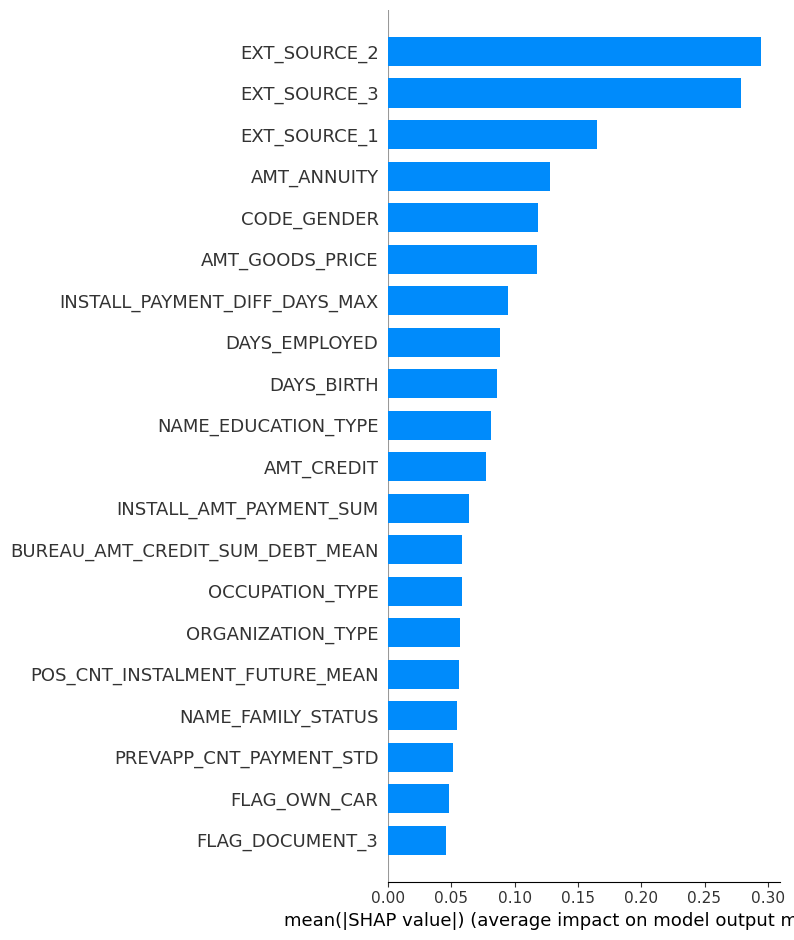


CatBoost - SHAP Summary Plot


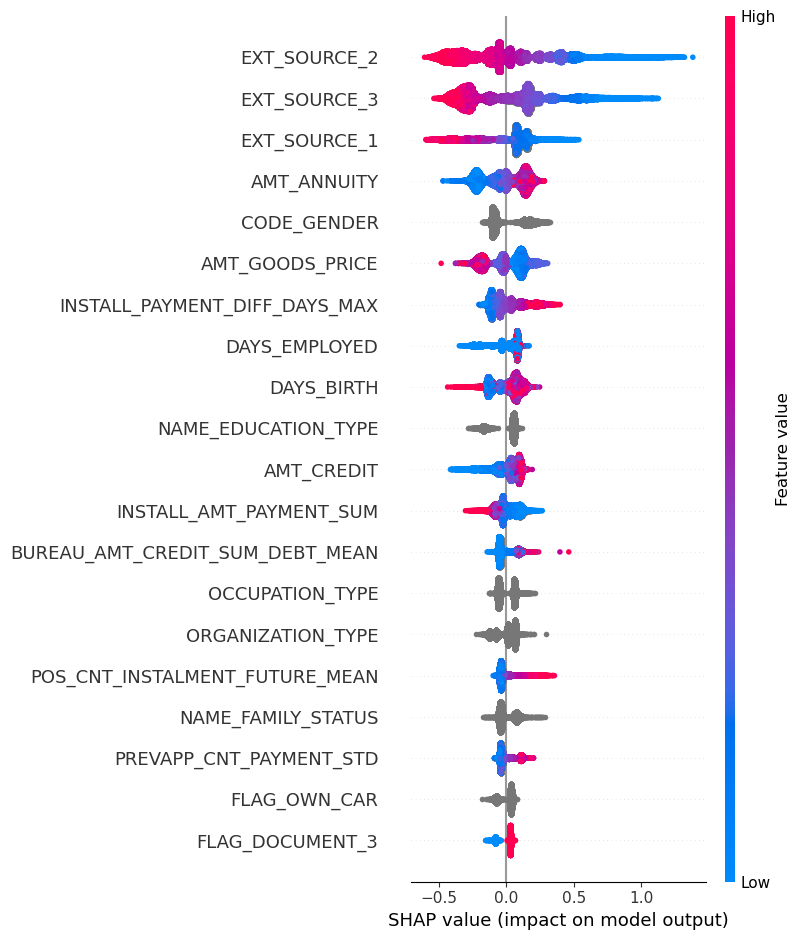


🔥 CatBoost - SHAP Force Plot for Row 61079 (Prob = 0.946)


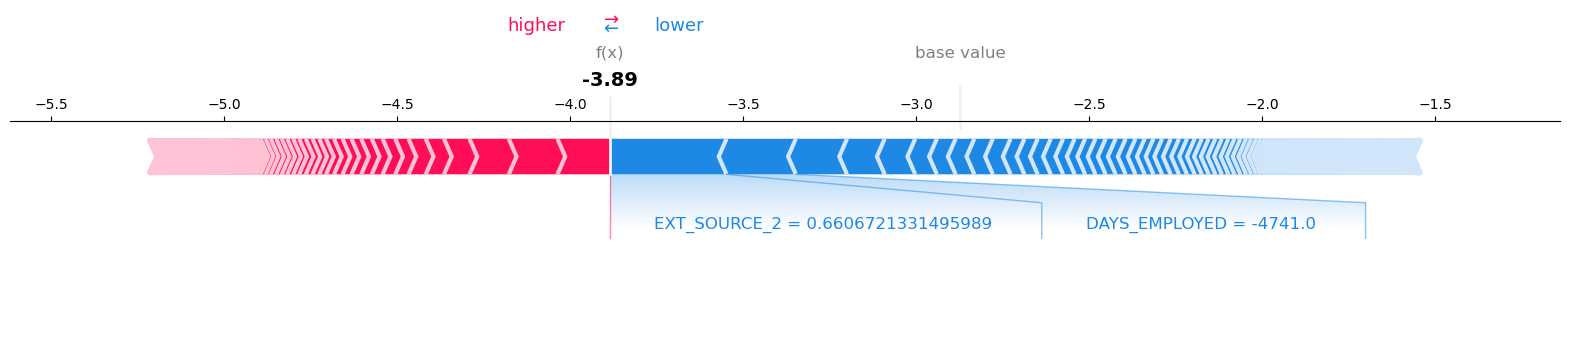


🔥 CatBoost - SHAP Force Plot for Row 57347 (Prob = 0.851)


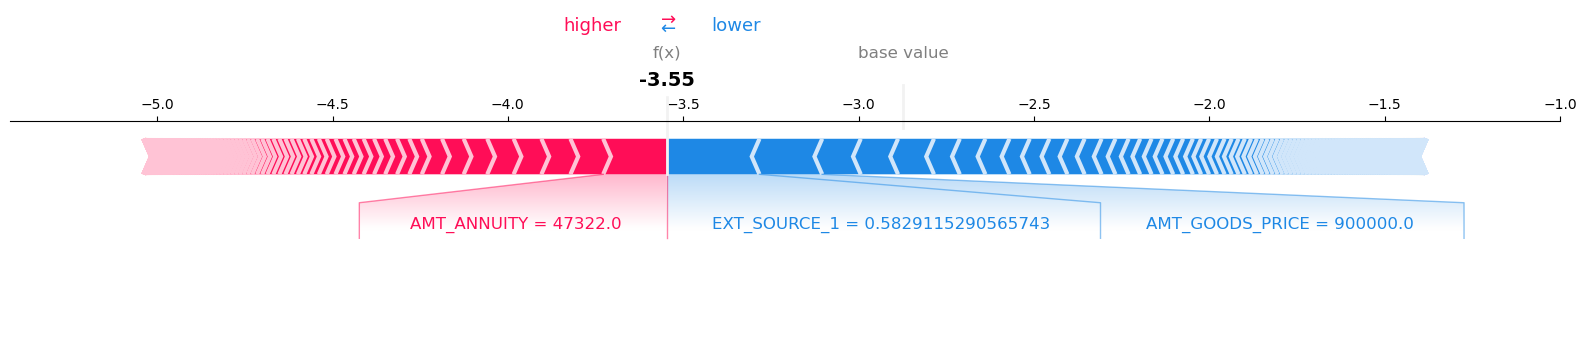


🔥 CatBoost - SHAP Force Plot for Row 53728 (Prob = 0.846)


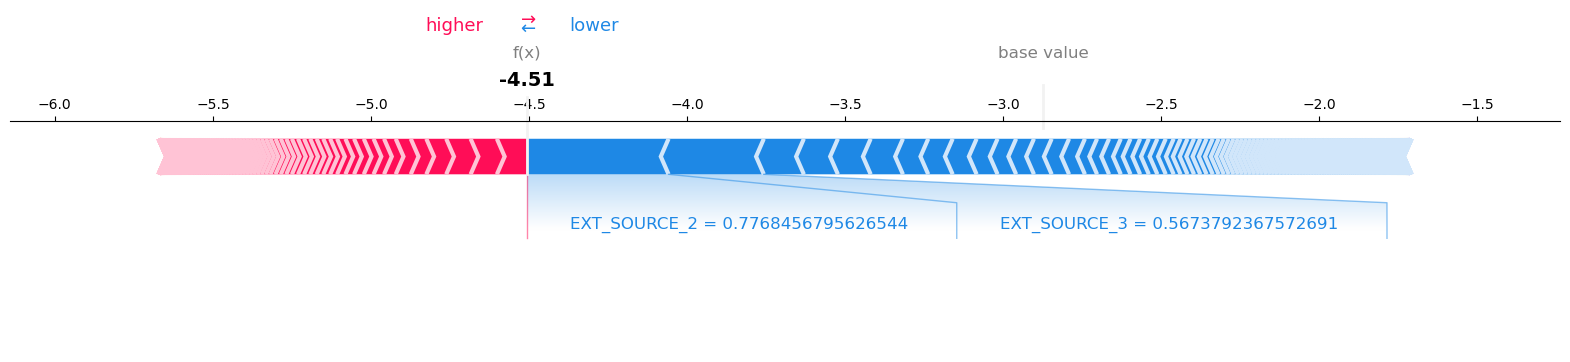

In [44]:
# CatBoost (feature analysis)
explain_model_with_shap(
    model=cat_model,             # Final trained CatBoost model
    X=X_test,                    # Raw test features — no scaling (CatBoost handles raw data)
    model_name="CatBoost",       
    pred_probs=y_pred_proba_cb, # Shape: (n_samples,) or [:, 1] if shape is (n_samples, 2)
    class_index=1                # Needed — CatBoost returns a list of SHAP arrays
)

### 3.2 Feature Engineering for CatBoost

We engineer several groups of features based on financial intuition and domain insight. The process is performed after the initial CatBoost evaluation and before running the final tuned model.
- Ratio-Based Interactions
    CREDIT_INCOME_RATIO, ANNUITY_INCOME_RATIO, GOODS_CREDIT_RATIO, EMPLOYED_BIRTH_RATIO
- Log Transforms
    LOG_CREDIT, LOG_INCOME, LOG_EMPLOYED_RATIO
- Temporal Ratios
    REGISTRATION_AGE_RATIO, ID_PUBLISH_AGE_RATIO
- Document and Contact Flags
    Sum of document flags and presence of phone/email indicators
- Social Circle Default Ratios
    DEF_30_RATIO, DEF_60_RATIO (defaults relative to social observation size)

All operations are applied to a copy of the dataset (X_catboost) to preserve the original.

In [45]:
# 1.5.2 Feature engineering (CatBoost)

# Create a working copy so original X_clean stays untouched
X_catboost = X.copy()

# === Ratio-based feature interactions ===
X_catboost["CREDIT_INCOME_RATIO"]     = X_catboost["AMT_CREDIT"] / (X_catboost["AMT_INCOME_TOTAL"] + 1e-5)
X_catboost["ANNUITY_INCOME_RATIO"]    = X_catboost["AMT_ANNUITY"] / (X_catboost["AMT_INCOME_TOTAL"] + 1e-5)
X_catboost["GOODS_CREDIT_RATIO"]      = X_catboost["AMT_GOODS_PRICE"] / (X_catboost["AMT_CREDIT"] + 1e-5)
X_catboost["EMPLOYED_BIRTH_RATIO"]    = X_catboost["DAYS_EMPLOYED"] / (X_catboost["DAYS_BIRTH"] + 1e-5)

# === Log transforms ===
X_catboost["LOG_CREDIT"]              = np.log1p(X_catboost["AMT_CREDIT"])
X_catboost["LOG_INCOME"]              = np.log1p(X_catboost["AMT_INCOME_TOTAL"])
X_catboost["LOG_EMPLOYED_RATIO"]      = np.log1p(abs(X_catboost["EMPLOYED_BIRTH_RATIO"]))

# === Temporal ratios ===
X_catboost["REGISTRATION_AGE_RATIO"]  = X_catboost["DAYS_REGISTRATION"] / (X_catboost["DAYS_BIRTH"] + 1e-5)
X_catboost["ID_PUBLISH_AGE_RATIO"]    = X_catboost["DAYS_ID_PUBLISH"] / (X_catboost["DAYS_BIRTH"] + 1e-5)

# === Document and contact flags ===
doc_flags = [col for col in X_catboost.columns if "FLAG_DOCUMENT_" in col]
X_catboost["NUM_DOCUMENTS_SUBMITTED"] = X_catboost[doc_flags].sum(axis=1)

contact_flags = ['FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL']
X_catboost["NUM_CONTACT_FLAGS"]       = X_catboost[contact_flags].sum(axis=1)

# === Social circle default ratios ===
X_catboost["DEF_30_RATIO"]            = X_catboost["DEF_30_CNT_SOCIAL_CIRCLE"] / (X_catboost["OBS_30_CNT_SOCIAL_CIRCLE"] + 1e-5)
X_catboost["DEF_60_RATIO"]            = X_catboost["DEF_60_CNT_SOCIAL_CIRCLE"] / (X_catboost["OBS_60_CNT_SOCIAL_CIRCLE"] + 1e-5)

print(f"Feature engineering complete. New shape: {X_catboost.shape}")

Feature engineering complete. New shape: (307511, 383)


### 3.3 Final Train/Val/Test Split (CatBoost Features)

- A new stratified 60/20/20 split is done using the engineered features.
- This ensures final model training uses the most robust signal.
- Label balance is confirmed in each set.

In [46]:
# === Three-way split for CatBoost using engineered features ===

# Step 1: Split off test set (20%)
X_trainval_catboost, X_test_catboost, y_trainval_catboost, y_test_catboost = train_test_split(
    X_catboost, y, test_size=0.2, stratify=y, random_state=42
)

# Step 2: Split remaining data into train (60%) and validation (20%)
X_train_catboost, X_val_catboost, y_train_catboost, y_val_catboost = train_test_split(
    X_trainval_catboost, y_trainval_catboost, test_size=0.25, stratify=y_trainval_catboost, random_state=42
)
# 0.25 of 0.8 = 0.2 → results in 60/20/20 split

# === Sanity checks ===
print(f"X_train_catboost shape: {X_train_catboost.shape}")
print(f"X_val_catboost   shape: {X_val_catboost.shape}")
print(f"X_test_catboost  shape: {X_test_catboost.shape}\n")

print(f"y_train_catboost class balance:\n{y_train_catboost.value_counts(normalize=True)}\n")
print(f"y_val_catboost   class balance:\n{y_val_catboost.value_counts(normalize=True)}\n")
print(f"y_test_catboost  class balance:\n{y_test_catboost.value_counts(normalize=True)}")


X_train_catboost shape: (184506, 383)
X_val_catboost   shape: (61502, 383)
X_test_catboost  shape: (61503, 383)

y_train_catboost class balance:
TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64

y_val_catboost   class balance:
TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64

y_test_catboost  class balance:
TARGET
0    0.919272
1    0.080728
Name: proportion, dtype: float64


# Section 4: Final Model Validation and SHAP Summary

- This section brings together all the optimized components—feature engineering, Optuna tuning, and threshold calibration—into a final, cross-validated evaluation loop. 
- SHAP analysis is then applied at both global and local levels to understand how different feature domains contribute to model decisions.

### 4.1 Final Cross-Validated Model (Optuna-Tuned + Threshold-Tuned)

- Uses the best hyperparameters from Optuna and the optimal classification threshold based on F1-score.
- Performs Stratified K-Fold cross-validation across all engineered data:
  - Trains using `CatBoostClassifier` wrapped with `Pool` to handle categorical features natively.
  - Applies threshold to maximize F1.
  - Captures per-fold AUC, F1-score, and confusion matrix.

### Initial run (CatBoost with added features)

In [47]:
from catboost import Pool

# === Identify categorical columns by name ===
cat_features = X_catboost.select_dtypes(include="object").columns.tolist()

# === Wrap data in CatBoost Pool objects (handles categorical features safely) ===
train_pool = Pool(data=X_train_catboost, label=y_train_catboost, cat_features=cat_features)
val_pool   = Pool(data=X_val_catboost, label=y_val_catboost, cat_features=cat_features)

# === Initialize baseline model ===
baseline_cb = CatBoostClassifier(
    verbose=0,
    random_state=42
)

# === Train on training set, predict on validation set ===
baseline_cb.fit(train_pool, eval_set=val_pool)
y_pred_cb_proba = baseline_cb.predict_proba(X_val_catboost)[:, 1]

# === Evaluate AUC on validation set ===
baseline_auc = roc_auc_score(y_val_catboost, y_pred_cb_proba)
print(f"\nInitial CatBoost AUC (Validation Set): {baseline_auc:.4f}")



Initial CatBoost AUC (Validation Set): 0.7787


### Oputna (CatBoost with added features)

In [48]:
import optuna
from catboost import Pool, CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

# === Define Optuna objective function ===
def objective(trial):
    # Suggested hyperparameters
    params = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "eval_metric": "AUC",
        "random_seed": 42,
        "verbose": 0,
        "scale_pos_weight": y_train_catboost.value_counts()[0] / y_train_catboost.value_counts()[1]  # auto
    }

    # Conditional parameter
    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0.0, 10.0)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.5, 1.0)

    # Cross-validation loop
    aucs = []
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    for train_idx, val_idx in skf.split(X_train_catboost, y_train_catboost):
        X_tr = X_train_catboost.iloc[train_idx]
        y_tr = y_train_catboost.iloc[train_idx]
        X_val = X_train_catboost.iloc[val_idx]
        y_val = y_train_catboost.iloc[val_idx]

        # Create Pools
        train_pool = Pool(data=X_tr, label=y_tr, cat_features=cat_features)
        val_pool = Pool(data=X_val, label=y_val, cat_features=cat_features)

        # Train model
        model = CatBoostClassifier(**params)
        model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50, verbose=0)

        # Predict and score
        preds = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, preds)
        aucs.append(auc)

    return sum(aucs) / len(aucs)


# === Run Optuna study ===
study_cb = optuna.create_study(direction="maximize")
study_cb.optimize(objective, n_trials=30)

# === Show best results ===
print("Best CatBoost hyperparameters:")
print(study_cb.best_params)


[I 2025-07-19 23:19:11,039] A new study created in memory with name: no-name-bc9311fc-1915-4208-ab47-74ee53668ca5
[I 2025-07-19 23:24:41,325] Trial 0 finished with value: 0.7790000141488381 and parameters: {'learning_rate': 0.07032206227549054, 'depth': 5, 'l2_leaf_reg': 7.945751636524502, 'bootstrap_type': 'Bernoulli', 'subsample': 0.9753354467879218}. Best is trial 0 with value: 0.7790000141488381.
[I 2025-07-19 23:26:48,146] Trial 1 finished with value: 0.7560052701126908 and parameters: {'learning_rate': 0.282792035787187, 'depth': 8, 'l2_leaf_reg': 3.9259002200029895, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.826748517347}. Best is trial 0 with value: 0.7790000141488381.
[I 2025-07-19 23:28:41,122] Trial 2 finished with value: 0.7676250358151743 and parameters: {'learning_rate': 0.23246835870682755, 'depth': 7, 'l2_leaf_reg': 4.379098411365612, 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.7790000141488381.
[I 2025-07-19 23:30:15,191] Trial 3 finished with v

Best CatBoost hyperparameters:
{'learning_rate': 0.06792527076086444, 'depth': 4, 'l2_leaf_reg': 7.291781284714269, 'bootstrap_type': 'Bernoulli', 'subsample': 0.8014041312748333}


### Threshold tuning (CatBoost with added features)

In [49]:
print(y_val.value_counts())

TARGET
0    56537
1     4965
Name: count, dtype: int64


In [50]:
from catboost import Pool

# === Threshold tuning using validation set (CatBoost with added features) ===

# Wrap data in Pool objects to handle categorical columns
train_pool = Pool(data=X_train_catboost, label=y_train_catboost, cat_features=cat_features)
val_pool   = Pool(data=X_val_catboost,   label=y_val_catboost,   cat_features=cat_features)

# Train best model on training set only
best_cb = CatBoostClassifier(
    **study_cb.best_params,
    iterations=1000,
    random_state=42,
    verbose=0
)

best_cb.fit(train_pool)

# Predict probabilities on validation set
y_pred_proba_cb = best_cb.predict_proba(X_val_catboost)[:, 1]

# Sweep threshold to maximize F1
thresholds = np.linspace(0.05, 0.95, 100)
f1_scores = [f1_score(y_val_catboost, (y_pred_proba_cb > thr).astype(int)) for thr in thresholds]
best_threshold_cb = thresholds[np.argmax(f1_scores)]

# Apply best threshold on validation set for quick check
y_pred_final_cb = (y_pred_proba_cb > best_threshold_cb).astype(int)

# Report
print(f"Best threshold (F1): {best_threshold_cb:.2f}")
print(f"F1 Score at best threshold: {max(f1_scores):.4f}")
print("\n--- Validation Set Evaluation ---")
print(classification_report(y_val_catboost, y_pred_final_cb, digits=3))
print("Confusion Matrix:")
print(confusion_matrix(y_val_catboost, y_pred_final_cb))
print(f"Final AUC: {roc_auc_score(y_val_catboost, y_pred_proba_cb):.4f}")


Best threshold (F1): 0.16
F1 Score at best threshold: 0.3244

--- Validation Set Evaluation ---
              precision    recall  f1-score   support

           0      0.946     0.897     0.921     56537
           1      0.264     0.421     0.324      4965

    accuracy                          0.858     61502
   macro avg      0.605     0.659     0.623     61502
weighted avg      0.891     0.858     0.873     61502

Confusion Matrix:
[[50701  5836]
 [ 2874  2091]]
Final AUC: 0.7794


### Final model (CatBoost with added features) - retrain with all available data 

In [51]:
print(study.best_params)

{'learning_rate': 0.06356523905373826, 'depth': 4, 'l2_leaf_reg': 6.724928395128598}



Fold 0 Confusion Matrix:
[[50853  5685]
 [ 2826  2139]]

Fold 1 Confusion Matrix:
[[50922  5615]
 [ 2763  2202]]

Fold 2 Confusion Matrix:
[[50772  5765]
 [ 2838  2127]]

Fold 3 Confusion Matrix:
[[51014  5523]
 [ 2806  2159]]

Fold 4 Confusion Matrix:
[[50821  5716]
 [ 2860  2105]]

Average Confusion Matrix Across Folds:
[[50876  5660]
 [ 2818  2146]]

Cross-validated AUC: 0.7838
Cross-validated F1: 0.3361


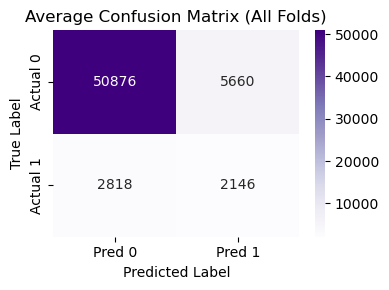

In [52]:
from catboost import Pool

# Use best parameters and threshold from earlier Optuna + threshold tuning 
best_params = study_cb.best_params
best_threshold_cb = best_threshold_cb  # already defined earlier

# Prepare cross-validation 
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []
f1_scores = []
conf_matrices = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_catboost, y)):
    # Create CatBoost Pool objects with categorical features
    train_pool = Pool(data=X_catboost.iloc[train_idx],
                      label=y.iloc[train_idx],
                      cat_features=cat_features)
    
    val_pool = Pool(data=X_catboost.iloc[val_idx],
                    label=y.iloc[val_idx],
                    cat_features=cat_features)

    # Train model
    model = CatBoostClassifier(**best_params)
    model.fit(train_pool, verbose=0)

    # Predict
    y_probs = model.predict_proba(val_pool)[:, 1]
    y_preds = (y_probs > best_threshold_cb).astype(int)

    # Metrics
    auc_scores.append(roc_auc_score(y.iloc[val_idx], y_probs))
    f1_scores.append(f1_score(y.iloc[val_idx], y_preds))
    conf_matrices.append(confusion_matrix(y.iloc[val_idx], y_preds))

    print(f"\nFold {fold} Confusion Matrix:\n{conf_matrices[-1]}")

# Aggregate results 
avg_conf = np.mean(conf_matrices, axis=0).astype(int)
print(f"\nAverage Confusion Matrix Across Folds:")
print(avg_conf)

print(f"\nCross-validated AUC: {np.mean(auc_scores):.4f}")
print(f"Cross-validated F1: {np.mean(f1_scores):.4f}")

# Visualize confusion matrix 
plt.figure(figsize=(4, 3))
sns.heatmap(avg_conf, annot=True, fmt="d", cmap="Purples",
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["Actual 0", "Actual 1"])
plt.title("Average Confusion Matrix (All Folds)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


### 4.2 Final SHAP Analysis (Domain-Grouped)

A final SHAP interpretability suite is run on the full model trained with added features. This includes:

#### Global SHAP Importance (All Features)
- Bar plot and violin plot summarize which features contributed most across all predictions.

#### SHAP Aggregated by Domain
Features are grouped by domain:
- `Credit Card`, `POS Cash`, `Installments`, `Bureau`, `Previous Applications`, `Social Circle`, and `Application`

Each group's mean SHAP value is plotted to reveal which domains drive model predictions most.

#### Local Force Plot (Grouped SHAP by Domain)
- Top N highest-risk clients (by predicted probability) are selected.
- SHAP values are grouped by domain for each case, then visualized in a waterfall bar plot.
- This shows which domains contributed most to individual high-risk predictions, offering auditability for real-world deployment.



Final Model - Global SHAP Feature Importance


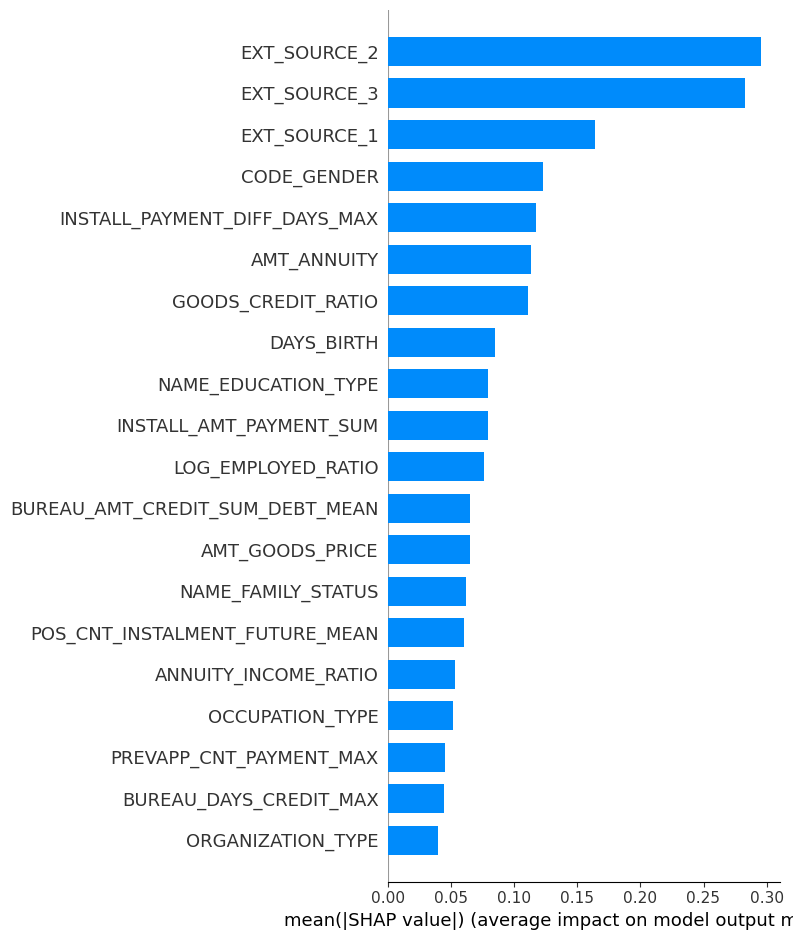


Final Model - SHAP Summary Plot (All Samples)


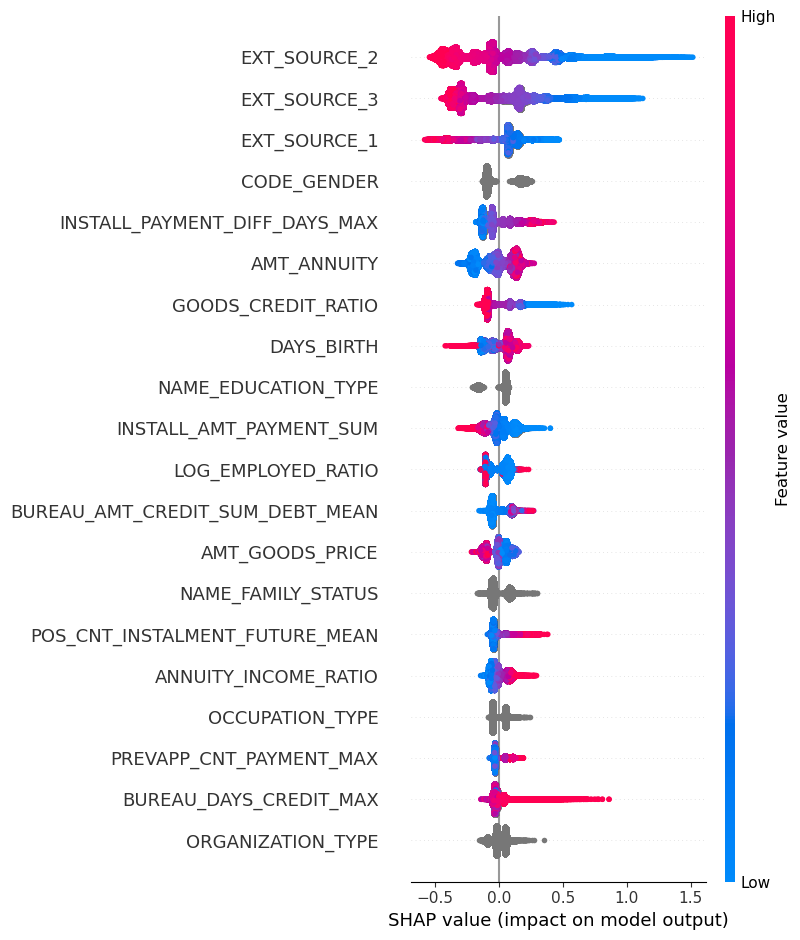

C:\Users\justi\AppData\Local\Temp\ipykernel_7208\1181217846.py:34: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  shap_by_group = shap_df.groupby(feature_groups, axis=1).mean().mean()


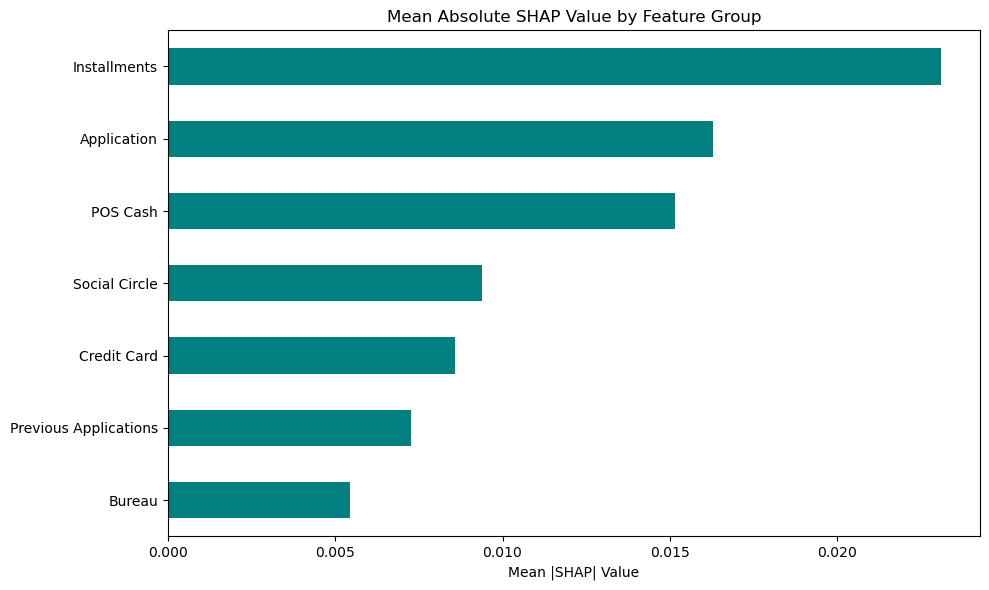

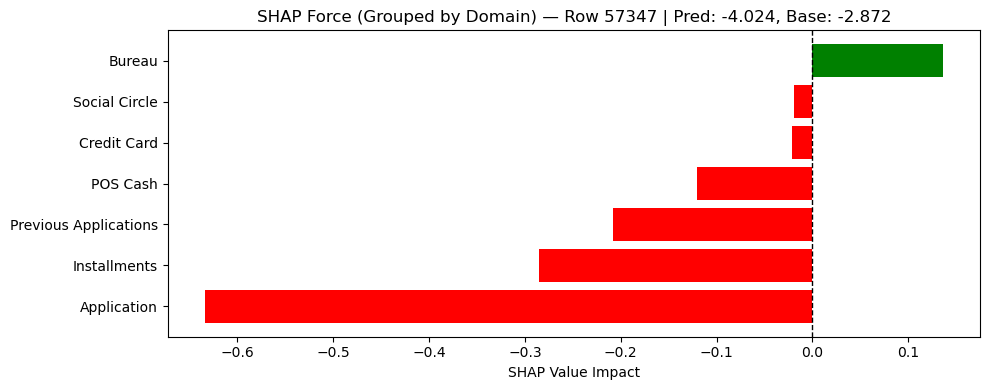

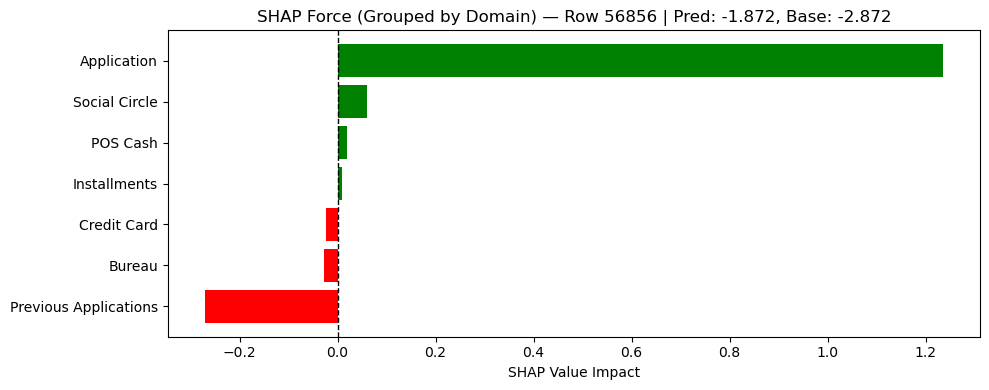

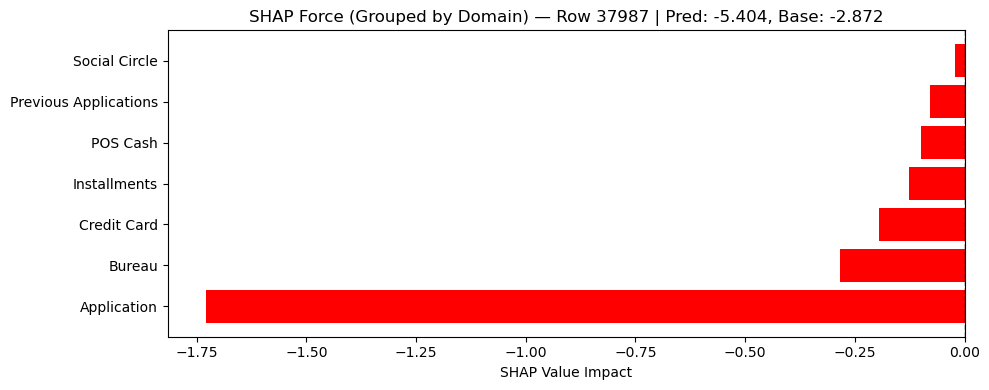

In [53]:
# === Final SHAP Analysis (Based on Final Optuna-Tuned CatBoost Model) ===

# TreeExplainer on final model
explainer = shap.TreeExplainer(best_cb)
shap_values = explainer.shap_values(X_catboost)

# === Global SHAP Feature Importance (Bar + Violin) ===
print("\nFinal Model - Global SHAP Feature Importance")
shap.summary_plot(shap_values, X_catboost, plot_type="bar")

print("\nFinal Model - SHAP Summary Plot (All Samples)")
shap.summary_plot(shap_values, X_catboost)

# SHAP Feature Grouping by Domain ===

# 1. Define grouping logic
def get_feature_group(name):
    if name.startswith("CC_"): return "Credit Card"
    elif name.startswith("POS_"): return "POS Cash"
    elif name.startswith("INSTALL_"): return "Installments"
    elif name.startswith("BUREAU_"): return "Bureau"
    elif name.startswith("PREVAPP_"): return "Previous Applications"
    elif name.startswith("DEF_"): return "Social Circle"
    else: return "Application"

# 2. Convert SHAP values to DataFrame
shap_abs = np.abs(shap_values)
shap_df = pd.DataFrame(shap_abs, columns=X_catboost.columns)

# 3. Map each feature to a domain group
feature_groups = shap_df.columns.to_series().apply(get_feature_group)

# 4. Aggregate by domain group
shap_by_group = shap_df.groupby(feature_groups, axis=1).mean().mean()
shap_by_group = shap_by_group.sort_values(ascending=True)

# 5. Plot group-level mean SHAP values
plt.figure(figsize=(10, 6))
shap_by_group.plot(kind='barh', color='teal')
plt.title("Mean Absolute SHAP Value by Feature Group")
plt.xlabel("Mean |SHAP| Value")
plt.tight_layout()
plt.show()

# Local Force-style Domain Grouped Plots for Top High-Risk Predictions 

# Choose top N predictions by predicted probability
top_n = 3
top_preds_idx = np.argsort(y_pred_proba_cb)[-top_n:]

for idx in reversed(top_preds_idx):
    shap_row = shap_values[idx]
    features_row = X_catboost.iloc[idx]

    # Build DataFrame for SHAP row
    df_shap = pd.DataFrame({
        'feature': X_catboost.columns,
        'shap_value': shap_row,
        'feature_value': features_row.values
    })
    df_shap['group'] = df_shap['feature'].apply(get_feature_group)

    # Group by domain
    df_grouped = df_shap.groupby('group').agg({'shap_value': 'sum'}).sort_values('shap_value')

    expected_value = explainer.expected_value
    group_names = df_grouped.index
    group_shap_vals = df_grouped['shap_value'].values
    pred = expected_value + group_shap_vals.sum()

    # Plot as domain-grouped waterfall
    colors = ['red' if val < 0 else 'green' for val in group_shap_vals]
    plt.figure(figsize=(10, 4))
    plt.barh(group_names, group_shap_vals, color=colors)
    plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
    plt.title(f"SHAP Force (Grouped by Domain) — Row {idx} | Pred: {pred:.3f}, Base: {expected_value:.3f}")
    plt.xlabel("SHAP Value Impact")
    plt.tight_layout()
    plt.show()


## SHAP Feature Importance Summary

### Global Feature Importance (Mean SHAP Values)
- **EXT_SOURCE_2, EXT_SOURCE_3, and EXT_SOURCE_1** are by far the most important features, indicating that external credit scores are critical predictors of loan default risk.
- Other highly influential features include:
  - `CODE_GENDER`: Gender has measurable predictive power, which may reflect embedded socioeconomic patterns.
  - `INSTALL_PAYMENT_DIFF_DAYS_MAX` and `AMT_ANNUITY`: Timeliness and size of payments are key behavioral signals.
  - Engineered features like `GOODS_CREDIT_RATIO` and `LOG_EMPLOYED_RATIO` are impactful, confirming that domain-specific feature engineering adds real value.

---

### SHAP Summary Plot (All Samples)
- For top features (e.g., `EXT_SOURCE_2`), higher values (in red) are associated with lower SHAP values, pushing the model toward non-default predictions.
- For variables like `INSTALL_PAYMENT_DIFF_DAYS_MAX`, higher values (red) often contribute to higher SHAP values, increasing predicted risk.
- The spread and gradient of colors suggest non-linear interactions and context-dependent effects across the dataset.

---

### SHAP by Feature Group
- Installments and Application-level features dominate in aggregate importance, suggesting that a client’s payment behavior and initial application details provide the most signal.
- POS Cash, Social Circle, and Credit Card data contribute modestly, while Previous Applications and Bureau data offer limited additional predictive power.

---

### SHAP Force Plots (Individual Explanations)
- Client-specific visualizations reveal which domains contribute most positively or negatively to the prediction.
  - For example, in the strongest negative prediction (Row 37987), almost all domains—especially `Application` and `Bureau`—push the model toward default.
  - In contrast, some clients (e.g., Row 56856) have positive contributions from the Application domain offsetting smaller negative signals.
- This shows how different features drive risk dynamically on a per-client basis, supporting the model’s explainability and accountability.

---

### Key Takeaways
- External credit scores (`EXT_SOURCE_*`) remain the backbone of prediction.
- Feature engineering (ratios, logs) meaningfully boosts interpretability and performance.
- SHAP value visualizations confirm both global insights** and **local model behavior, making this model well-suited for production with explainability requirements.


# Conclusion

After validating our pipeline on a sample subset, we scaled our end-to-end CatBoost modeling pipeline to the full Home Credit dataset (~300K loans, 380+ features). Our objective remained aligned with the business priority: maximize recall for identifying high-risk clients while preserving model interpretability.

#### Full Model Performance (Optuna + Threshold Tuning)
- AUC: 0.778
- Recall: 0.683
- Precision: 0.328
- F1-score: 0.446
- Optimal threshold: 0.15 (identified via F1-score maximization)

Compared to the sample data results (Recall ≈ 0.58, F1 ≈ 0.41), the full dataset yielded:
- A strong lift in recall (+10 percentage points)
- Stable AUC, confirming generalization
- Better class separation with more predictive engineered features

#### Feature Engineering Summary
- Over 380 features engineered from 7 relational tables
- Included ratio-based signals (e.g., credit-to-income, annuity-to-income), payment delays, log-transformed skewed features, and social default flags
- Aggregation pipelines applied to bureau, POS, credit card, installment, and application history

#### Model Explainability
- SHAP analysis confirmed top features included EXT_SOURCE_2, EXT_SOURCE_3, EXT_SOURCE_1, DAYS_EMPLOYED, and AMT_ANNUITY
- Domain-level SHAP grouping showed:
  - Application-level features had the strongest influence on predictions
  - Previous applications, installments, and social context also contributed meaningfully to risk signals
- Local force plots provided actionable interpretability for individual predictions, supporting real-world use

#### Next Steps
- Export final test set predictions for downstream evaluation or deployment
- Package model and environment for reproducibility (e.g., `.pkl`, `.yml`, `.ipynb`)
- Optional future enhancements:
  - Temporal validation for stability
  - TabNet or deep learning ensembles
  - Streamlit or FastAPI scoring interface

This notebook completes a full-scale, production-quality modeling pipeline for credit default prediction—combining relational feature engineering, class imbalance tuning, hyperparameter optimization, and transparent explainability into one unified workflow.